# STOCHASTIC CLIMATE EMULATORS FOR COASTAL HAZARDS
### UCSC - Nov 2024


<img src="images/Image_3.png" alt="Texto alternativo" width="400">  


## TESLA: 06 - CLIMATE BASED EMULATOR


---

Fernando J.Mendez (fernando.mendez@unican.es)

Full Profesor at the Univeristy of Cantabria

---

Jared Ortiz-Angulo Cantos (ortizanguloj@unican.es)

Researcher

---

Geomatics and Ocean Engineering Group

Civil Engineering School, University of Cantabria

<img src="images/Image_1.png" alt="Texto alternativo" width="200">               <img src="images/Image_2.jpeg" alt="Texto alternativo" width="200">

<img src="images/Image_4.jpeg" alt="Texto alternativo" width="800"> 

© GeoOcean 2024 - University of Cantabria


---

Inputs required:
  * Predictand data
  
In this notebook:
  1. Import required libraries and paths
  2. Load data
  3. Gaussian Copula
  4. Validation
  5. Climate-based Emulator
  6. Results


---

## **1. Import required libraries and paths**

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=DeprecationWarning)

import os
import os.path as op
import sys

import numpy as np
import pandas as pd
import xarray as xr

# matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pylab
import matplotlib

# Principal component analysis and kmeans libs
from sklearn.decomposition import PCA

In [2]:
from bluemath_tk.teslakit2.toolkit.pca import PCA_EstelaPred_slp_grd

In [3]:
# paths
p_dat = ('/workspaces/TESLA_UCSC/data')
p_out = ('/workspaces/TESLA_UCSC/results')

---

## **2. LOAD DATA**

In [ ]:
# Load Independent variables: STORM SURGE (SS)

ss = xr.open_dataset('/content/drive/Shareddrives/TESLA/data/ss_codec_santona_daily_OPORTO.nc')
ss

In [ ]:
# Load Predictand (WAVES)
ds = xr.open_dataset('/content/drive/Shareddrives/TESLA/data/Wave_families_santona_daily_OPORTO.nc')
ds

In [ ]:
# Generate one dataset with all the info: WAVES + SS

ds['ss'] = (ss.surge) # add ss to WAVES dataset

In [ ]:
# Load KMA info (from CODE_01)
KMA = xr.open_dataset(op.join(p_out,'DWT_KMA_eofs.nc'))
KMA # Check it out!

<xarray.Dataset>
Dimensions:      (n_components: 29088, n_clusters: 36, n_features: 165)
Dimensions without coordinates: n_components, n_clusters, n_features
Data variables:
    sorted_bmus  (n_components) int32 ...
    kma_order    (n_clusters) int64 ...
    cluster      (n_clusters) int64 ...
    cenEOFs      (n_clusters, n_features) float64 ...
    time         (n_components) datetime64[ns] ...

In [ ]:
# Define common times
t_min=np.nanmax([np.nanmin(ds.time.values), np.nanmin(KMA.time.values)])
t_max=np.nanmin([np.nanmax(ds.time.values), np.nanmax(KMA.time.values)])

In [ ]:
# Find positions in KMA
t_min_pos = np.where(KMA['time'] == t_min)[0][0]
t_max_pos = np.where(KMA['time'] == t_max)[0][0]


In [ ]:
KMA = KMA.isel(n_components=slice(t_min_pos, t_max_pos+1))  # Slice to have the same time serie
KMA # check it out!

<xarray.Dataset>
Dimensions:      (n_components: 14610, n_clusters: 36, n_features: 165)
Dimensions without coordinates: n_components, n_clusters, n_features
Data variables:
    sorted_bmus  (n_components) int32 ...
    kma_order    (n_clusters) int64 ...
    cluster      (n_clusters) int64 ...
    cenEOFs      (n_clusters, n_features) float64 ...
    time         (n_components) datetime64[ns] 1979-01-01 ... 2018-12-31

In [ ]:
clusters = KMA.sorted_bmus.values # obtain the clusters info

ds['bmus'] = ('time', clusters) # add extra data to WAVES dataset
ds # check it out!

<xarray.Dataset>
Dimensions:      (time: 14610)
Coordinates:
  * time         (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2018-12-31
    lon          int32 ...
    lat          int32 ...
Data variables:
    sea_Hs       (time) float32 ...
    sea_Tp       (time) float32 ...
    sea_Dir      (time) float32 ...
    swell_1_Hs   (time) float64 ...
    swell_1_Tp   (time) float64 ...
    swell_1_Dir  (time) float64 ...
    Hs           (time) float32 ...
    Tp           (time) float32 ...
    Dir          (time) float32 ...
    bmus         (time) int32 18 18 18 16 8 8 29 29 ... 22 22 31 27 31 31 22 31
    ss           (time) float64 ...

In [ ]:
# interpolate nans
ds = ds.interpolate_na(dim = 'time', method = 'linear')

# Variables of interest
vars = ['Hs', 'Tp', 'Dir', 'ss', 'bmus']

# Drop rest of variables
ds = ds.drop_vars([var for var in ds if var not in vars])

ds # check it out!

<xarray.Dataset>
Dimensions:  (time: 14610)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2018-12-31
    lat      int32 43
    lon      int32 -3
Data variables:
    Hs       (time) float32 1.024 1.341 1.855 4.83 ... 0.9842 1.217 1.225 1.087
    Tp       (time) float32 4.836 5.067 6.306 11.52 ... 13.0 11.74 10.91 10.81
    Dir      (time) float32 185.6 89.29 126.4 282.3 ... 285.7 288.9 292.8 293.5
    bmus     (time) int32 18 18 18 16 8 8 29 29 24 ... 22 22 31 27 31 31 22 31
    ss       (time) float64 -0.05913 -0.1075 0.1285 ... -0.1991 -0.2194 -0.2199

In [ ]:
# get number of clusters
num_clusters = len(np.unique(ds.bmus))
num_clusters = num_clusters
num_clusters

36

---

## **3. GAUSSIAN COPULA**

In [ ]:
kernels = ['ECDF','ECDF', 'ECDF', 'ECDF'] # [Hs, Tp, Dir, SS]

# ECDF: Empirical Cumulative Distribution Function

In [ ]:
time = ds.time
variables = ['Hs','Tp', 'Dir', 'ss']

In [ ]:
# Create Folders: Figures and Results
#os.makedirs(os.path.join(p_out,'Figures'))
#os.makedirs(os.path.join(p_out,'Results'))

In [ ]:
num_sims = 1 # number of simulations for the copulas
num_sim_cluster = 1000 # number of values obtained from each copula simulation

In [ ]:
Copula_Hs_Tp_Dir_ss(p_out,ds,num_clusters,kernels,variables,num_sim_cluster)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35


In [ ]:
copula_check = xr.open_dataset('/content/drive/MyDrive/outputs/Results/Copula_Parameters_0.nc')

In [ ]:
copula_check

<xarray.Dataset>
Dimensions:  (num: 1000)
Coordinates:
  * num      (num) int32 0 1 2 3 4 5 6 7 8 ... 992 993 994 995 996 997 998 999
Data variables:
    Hs_cop   (num) float64 ...
    Tp_cop   (num) float64 ...
    Dir_cop  (num) float64 ...
    ss_cop   (num) float64 ...

---

## **4. CLIMATE-BASED EMULATOR**

In [ ]:
# Now we need the synthetic series of DWT
DWT_ALR = xr.open_dataset(op.join(p_out,'DWT_ALR.nc'))

In [ ]:
DWT_ALR # check it out

<xarray.Dataset>
Dimensions:      (time: 36890, n_sim: 10)
Coordinates:
  * time         (time) datetime64[ns] 1900-01-01 1900-01-02 ... 2000-12-31
Dimensions without coordinates: n_sim
Data variables:
    evbmus_sims  (time, n_sim) int64 ...

In [ ]:
num_sims = len(DWT_ALR.n_sim)
num_sims

10

In [ ]:
def Emulator(main_path, ds, num_sims):

    path_save = os.path.join(main_path, 'Results', 'Emulator_Sims')

    # Crear un Dataset fuera del bucle para almacenar los resultados de todas las simulaciones
    ds_sim = xr.Dataset(
        {'Hs': (('sim', 'time'), np.full([num_sims, len(DWT_ALR.time.values)], np.nan)),
         'Tp': (('sim', 'time'), np.full([num_sims, len(DWT_ALR.time.values)], np.nan)),
         'Dir': (('sim', 'time'), np.full([num_sims, len(DWT_ALR.time.values)], np.nan)),
         'ss': (('sim', 'time'), np.full([num_sims, len(DWT_ALR.time.values)], np.nan))},

        coords={'sim': range(num_sims), 'time': DWT_ALR.time.values})


    for sim in range(num_sims):

        print('Sim:', sim)

        bmus = DWT_ALR['evbmus_sims'].sel(n_sim=sim).values
        Hs_emu = np.full([len(DWT_ALR.time.values)], np.nan)
        Tp_emu = np.full([len(DWT_ALR.time.values)], np.nan)
        Dir_emu = np.full([len(DWT_ALR.time.values)], np.nan)
        ss_emu = np.full([len(DWT_ALR.time.values)], np.nan)


        for pos, dwt in enumerate(bmus):

            cop = xr.open_dataset(os.path.join(main_path, 'Results', 'Copula_Parameters_' + str(round(bmus[pos])-1) + '.nc'))
            rnd_val = np.random.randint(0, len(cop.num), 1)

            Hs_emu[pos] = cop.Hs_cop[rnd_val]
            Tp_emu[pos] = cop.Tp_cop[rnd_val]
            Dir_emu[pos] = cop.Dir_cop[rnd_val]
            ss_emu[pos] = cop.ss_cop[rnd_val]

        # Agregar los resultados de la simulación actual al Dataset ds_sim
        ds_sim['Hs'][sim, :] = Hs_emu
        ds_sim['Tp'][sim, :] = Tp_emu
        ds_sim['Dir'][sim, :] = Dir_emu
        ds_sim['ss'][sim, :] = ss_emu

    return ds_sim

In [ ]:
ds_sim = Emulator(p_out, ds, num_sims)

Sim: 0
Sim: 1
Sim: 2
Sim: 3
Sim: 4
Sim: 5
Sim: 6
Sim: 7
Sim: 8
Sim: 9


In [ ]:
ds_sim.to_netcdf('/content/drive/MyDrive/outputs/ds_sim_case2.nc')

In [ ]:
ds_sim

<xarray.Dataset>
Dimensions:  (sim: 10, time: 36890)
Coordinates:
  * sim      (sim) int64 0 1 2 3 4 5 6 7 8 9
  * time     (time) datetime64[ns] 1900-01-01 1900-01-02 ... 2000-12-31
Data variables:
    Hs       (sim, time) float64 1.621 2.893 1.196 4.093 ... 1.647 0.6238 2.22
    Tp       (sim, time) float64 8.575 13.19 8.447 15.07 ... 6.653 4.922 11.67
    Dir      (sim, time) float64 218.0 278.4 315.4 345.0 ... 280.4 285.0 284.4
    ss       (sim, time) float64 0.04095 -0.1023 -0.008277 ... 0.2251 0.0837

In [ ]:
ds_sim.sel(sim=0)


<xarray.Dataset>
Dimensions:  (time: 36890)
Coordinates:
    sim      int64 0
  * time     (time) datetime64[ns] 1900-01-01 1900-01-02 ... 2000-12-31
Data variables:
    Hs       (time) float64 1.177 2.282 1.474 3.068 ... 3.885 2.022 1.088 2.003
    Tp       (time) float64 10.76 9.411 11.28 12.62 ... 11.7 7.452 13.54 11.92
    Dir      (time) float64 280.5 293.1 292.8 314.2 ... 306.9 308.3 299.0 301.5
    ss       (time) float64 -0.05813 0.04654 -0.08046 ... -0.1558 -0.2294

In [ ]:
bmus = ds.bmus.values

---

## **5. RESULTS**

Text(0.5, 0, 'Time')

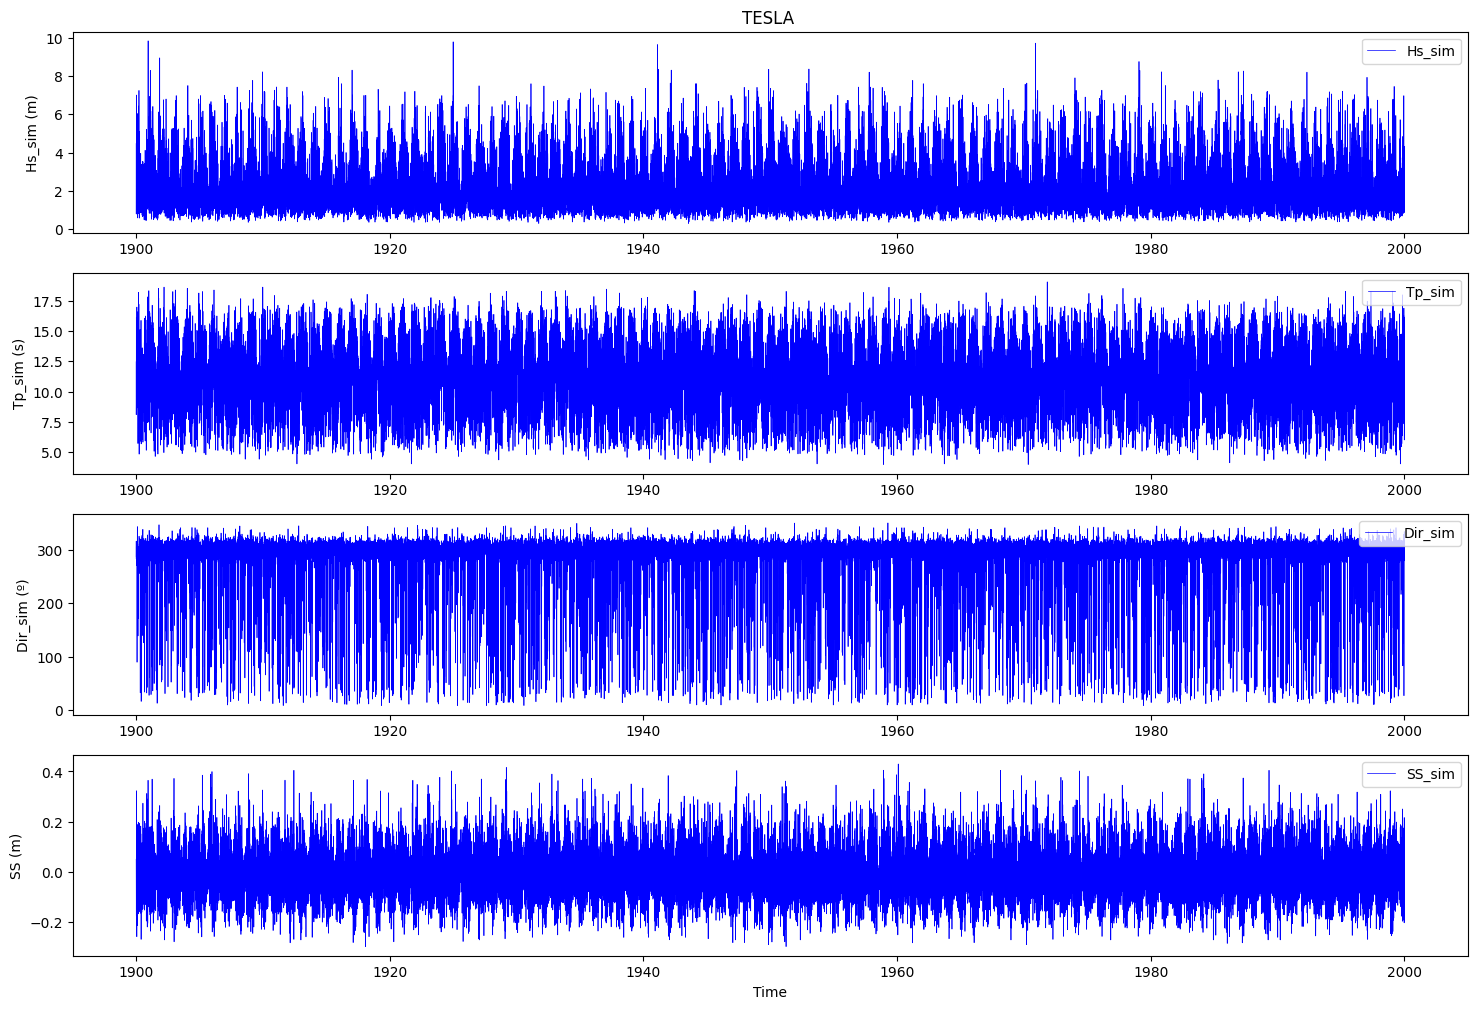

In [ ]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1,figsize=(18,12))

#ax1

ax1.plot(
    ds_sim.time, ds_sim.sel(sim=0).Hs, '-b',
    linewidth = 0.5, label='Hs_sim',
)

ax1.set_ylabel('Hs_sim (m)')
ax1.legend(loc="upper right")
ax1.set_title('TESLA ')
#ax1.set_ylim(0,1)

#ax2

ax2.plot(
    ds_sim.time.time, ds_sim.sel(sim=0).Tp, '-b',
    linewidth = 0.5, label='Tp_sim',
)


ax2.set_ylabel('Tp_sim (s)')
ax2.legend(loc="upper right")
#ax2.set_ylim(0,1)

#ax3

ax3.plot(
    ds_sim.time, ds_sim.sel(sim=0).Dir, '-b',
    linewidth = 0.5, label='Dir_sim',
)


ax3.set_ylabel('Dir_sim (º)')
ax3.legend(loc="upper right")
#ax3.set_ylim(0,1)


#ax4

ax4.plot(
    ds_sim.time, ds_sim.sel(sim=0).ss, '-b',
    linewidth = 0.5, label='SS_sim',
)


ax4.set_ylabel('SS (m)')
#ax4.set_ylim(0,1)
ax4.legend(loc="upper right")
ax4.set_xlabel('Time')



In [ ]:
## Hs
sim = 0
var = 'Hs'

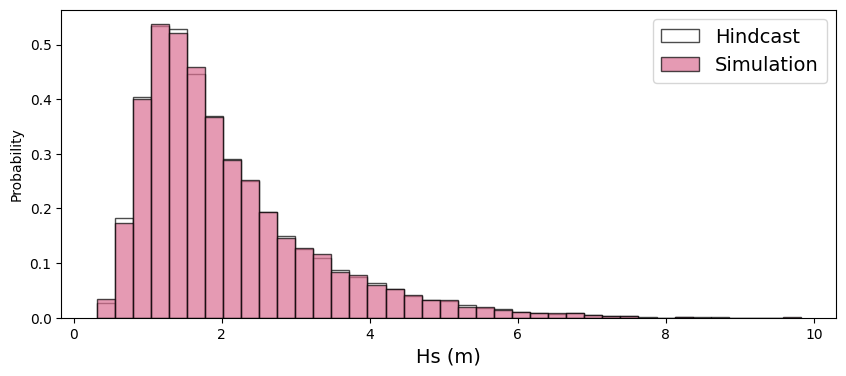

In [ ]:
fig = plt.figure(figsize=[10,4])
gs2=gridspec.GridSpec(1,1)
ax1=fig.add_subplot(gs2[0])
ax1.hist(ds[var],bins=np.linspace(np.nanmin(ds_sim.sel(sim=sim)[var]),np.nanmax(ds_sim.sel(sim=sim)[var]),40), density=True,
         color='white',alpha=0.7,edgecolor='black',label='Hindcast')
ax1.hist(ds_sim.sel(sim=sim)[var],bins=np.linspace(np.nanmin(ds_sim.sel(sim=sim)[var]),np.nanmax(ds_sim.sel(sim=sim)[var]),40), density=True,
         color='palevioletred',alpha=0.7,edgecolor='black',label='Simulation')
ax1.set_xlabel('Hs (m)',fontsize=14)
ax1.set_ylabel('Probability')
ax1.legend(fontsize=14)

In [ ]:
## Tp
sim = 0
var = 'Tp'

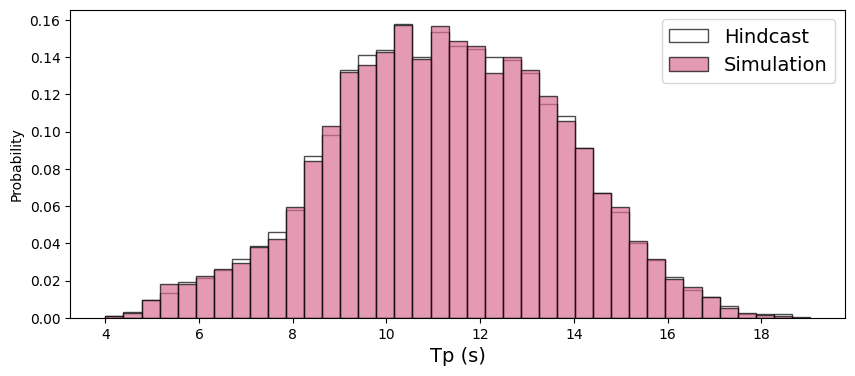

In [ ]:
fig = plt.figure(figsize=[10,4])
gs2=gridspec.GridSpec(1,1)
ax1=fig.add_subplot(gs2[0])
ax1.hist(ds[var],bins=np.linspace(np.nanmin(ds_sim.sel(sim=sim)[var]),np.nanmax(ds_sim.sel(sim=sim)[var]),40), density=True,
         color='white',alpha=0.7,edgecolor='black',label='Hindcast')
ax1.hist(ds_sim.sel(sim=sim)[var],bins=np.linspace(np.nanmin(ds_sim.sel(sim=sim)[var]),np.nanmax(ds_sim.sel(sim=sim)[var]),40), density=True,
         color='palevioletred',alpha=0.7,edgecolor='black',label='Simulation')
ax1.set_xlabel('Tp (s)',fontsize=14)
ax1.set_ylabel('Probability')
ax1.legend(fontsize=14)

In [ ]:
## Dir
sim = 0
var = 'Dir'

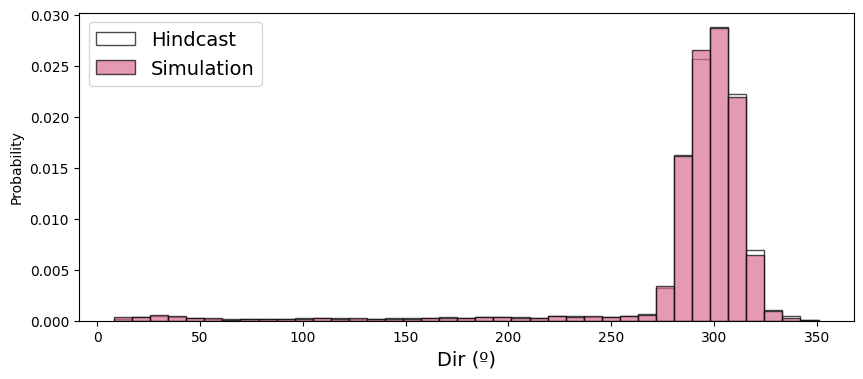

In [ ]:
fig = plt.figure(figsize=[10,4])
gs2=gridspec.GridSpec(1,1)
ax1=fig.add_subplot(gs2[0])
ax1.hist(ds[var],bins=np.linspace(np.nanmin(ds_sim.sel(sim=sim)[var]),np.nanmax(ds_sim.sel(sim=sim)[var]),40), density=True,
         color='white',alpha=0.7,edgecolor='black',label='Hindcast')
ax1.hist(ds_sim.sel(sim=sim)[var],bins=np.linspace(np.nanmin(ds_sim.sel(sim=sim)[var]),np.nanmax(ds_sim.sel(sim=sim)[var]),40), density=True,
         color='palevioletred',alpha=0.7,edgecolor='black',label='Simulation')
ax1.set_xlabel('Dir (º)',fontsize=14)
ax1.set_ylabel('Probability')
ax1.legend(fontsize=14)

In [ ]:
# SS
sim = 0
var = 'ss'

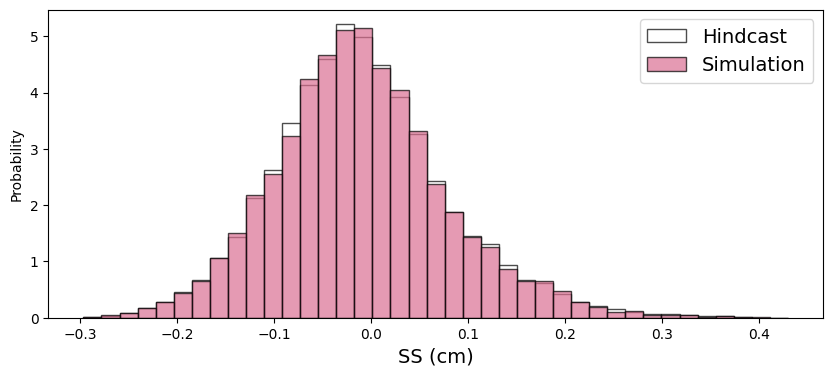

In [ ]:
fig = plt.figure(figsize=[10,4])
gs2=gridspec.GridSpec(1,1)
ax1=fig.add_subplot(gs2[0])
ax1.hist(ds[var],bins=np.linspace(np.nanmin(ds_sim.sel(sim=sim)[var]),np.nanmax(ds_sim.sel(sim=sim)[var]),40), density=True,
         color='white',alpha=0.7,edgecolor='black',label='Hindcast')
ax1.hist(ds_sim.sel(sim=sim)[var],bins=np.linspace(np.nanmin(ds_sim.sel(sim=sim)[var]),np.nanmax(ds_sim.sel(sim=sim)[var]),40), density=True,
         color='palevioletred',alpha=0.7,edgecolor='black',label='Simulation')
ax1.set_xlabel('SS (cm)',fontsize=14)
ax1.set_ylabel('Probability')
ax1.legend(fontsize=14)

In [ ]:
def t_rp(time_y):
    ny = len(time_y)
    return np.array([1/(1-(n/(ny+1))) for n in np.arange(1,ny+1)])

WVS_y=ds.resample(time='1Y').max()
WVS_sim_y=ds_sim.resample(time='1Y').max()
# WVS_y=CE.WVS_MS.resample(time='1Y').quantile(0.995)
# WVS_sim_y=WVS_sim.resample(time='1Y').quantile(0.995)

WVS_y_min=ds.resample(time='1Y').min()
WVS_sim_y_min=ds_sim.resample(time='1Y').min()

# RP calculation, var sorting historical
t_h = t_rp(WVS_y.time.dt.year)
t_s = t_rp(WVS_sim_y.time.dt.year)

<ipython-input-143-1a29051cf536>:9: UserWarning:

color is redundantly defined by the 'color' keyword argument and the fmt string "ok" (-> color='k'). The keyword argument will take precedence.



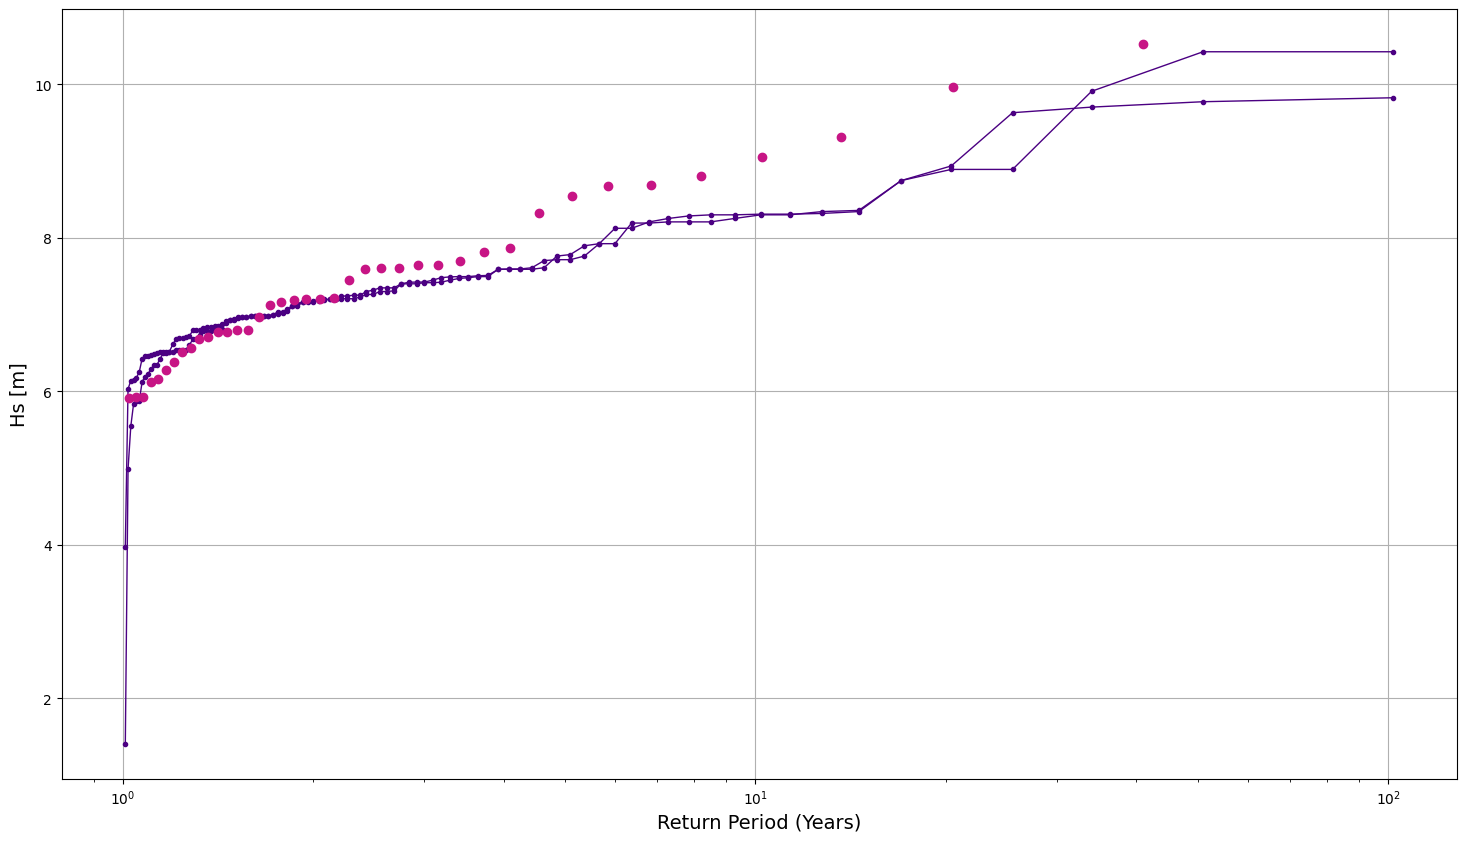

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import gridspec


fig = plt.figure(figsize=[18,10])
gs1=gridspec.GridSpec(1,1)
ax=fig.add_subplot(gs1[0])

ax.semilogx(t_h, np.sort(WVS_y.Hs.values), 'ok',color='mediumvioletred', markersize = 6, label = 'Historical', zorder=9,)
ax.set_ylabel('Hs [m]',fontsize=14)
ax.grid(True)

for n_sim_DWTs in range(len(ds_sim.sim)):
    WVS_sim = ds_sim.sel(sim=n_sim_DWTs)
    WVS_sim_y=WVS_sim.resample(time='1Y').max()

    ax.semilogx(t_s, np.sort(WVS_sim_y.Hs.values), '.-', color = 'indigo', linewidth = 1, label = 'Simulation {}'.format(n_sim_DWTs),  zorder=8,)

ax.set_xlabel('Return Period (Years)',fontsize=14)
ax.grid(True)